# Train a Quantized CNN on MNIST with Brevitas

<font color="red">**Live FINN tutorial:** We recommend clicking **Cell -> Run All** when you start reading this notebook for "latency hiding".</font>

In this notebook, we will show how to create, train and export a quantized Multi Layer Perceptron (MLP) with quantized weights and activations with [Brevitas](https://github.com/Xilinx/brevitas).

**You won't need a GPU to train the neural net.** This MLP will be small enough to train on a modern x86 CPU, so no GPU is required to follow this tutorial  Alternatively, we provide pre-trained parameters for the MLP if you want to skip the training entirely.


## A quick introduction to the task and the dataset

*Performance considerations:* FPGAs are commonly used for implementing high-performance packet processing systems that still provide a degree of programmability. To avoid introducing bottlenecks on the network, the DNN implementation must be capable of detecting malicious ones at line rate, which can be millions of packets per second, and is expected to increase further as next-generation networking solutions provide increased
throughput. This is a good reason to consider FPGA acceleration for this particular use-case.

## Outline
-------------

* [Load Dataset](#load_dataset) 
* [Define the Quantized MLP Model](#define_quantized_mlp)
* [Define Train and Test  Methods](#train_test)
    * [(Option 1) Train the Model from Scratch](#train_scratch)
    * [(Option 2) Load Pre-Trained Parameters](#load_pretrained)
* [Network Surgery Before Export](#network_surgery)
* [Export to FINN-ONNX](#export_finn_onnx)

In [1]:
import onnx
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("Using device: ", device)

Using device:  cuda:0


**This is important -- always import onnx before torch**. This is a workaround for a [known bug](https://github.com/onnx/onnx/issues/2394).

## Set up DataLoader

Following either option, we now have access to the quantized dataset. We will wrap the dataset in a PyTorch `DataLoader` for easier access in batches.

In [5]:
## Load dataset
import numpy as np
import cv2
import os
import struct
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
from random import randrange
import copy


print("Loading dataset")

none_img_dir = "/home/nm/Downloads/VOCdevkit/VOC2012/single_or_no_person_dataset/no_person_images"
one_img_dir = "/home/nm/Downloads/VOCdevkit/VOC2012/single_or_no_person_dataset/single_person_images"
none_txt_dir = "/home/nm/Downloads/VOCdevkit/VOC2012/single_or_no_person_dataset/no_person_txt"
one_txt_dir = "/home/nm/Downloads/VOCdevkit/VOC2012/single_or_no_person_dataset/single_person_txt"


train_images = []
train_labels = []
test_images = []
test_labels = []

temp_label = []


# ---------------------------------#

orig_img_size = 500
resized_size = 224

color = 1 ## 1 = color, 0 = grayscale

with_personless = 0 ## 1 = include images without people

augment_ratio = 5.9 #3.2 # higher number = bigger augmented dataset

# ---------------------------------#

if with_personless == 0:
    range_i = 1
if with_personless == 1:
    range_i = 2

dims = (resized_size, resized_size) #(256,256) # dimensions of images to train/test with

label_scale = dims[0] / orig_img_size

## KEEP IN MIND GRAYSCALE, INCLUDE COLORS (3x channels) 

num_test = 0
num_train = 0


def to_onehot(label, n_categories, img_dim):
    n_categories = round(n_categories)
    one_hot_label = np.zeros(n_categories*4) # 4 = num classes, concat'ed multihot vector
    scaling = float(n_categories) / float(img_dim)
    for i in range(len(label)):
        # indexing starts at 1 and tensor indexing starts at 0
        label_scaled = round(label[i] * scaling)
        if label_scaled > (n_categories-1):
            label_scaled = n_categories-1
        if label_scaled < 0:
            label_scaled = 0
        one_hot_label[(label_scaled+(n_categories*i))] = float(1.0) ## -1?
    return one_hot_label


def shift_image(img,tx,ty):  
    tmp_img = copy.deepcopy(img)
    num_rows, num_cols = tmp_img.shape[:2]
    # Creating a translation matrix
    translation_matrix = np.float32([ [1,0,tx], [0,1,ty] ])
    # Image translation
    img_translation = cv2.warpAffine(tmp_img, translation_matrix, (num_cols,num_rows))
    return img_translation


def shift_img_label(img, label, tx, ty):
    shifted_image = shift_image(img, tx, ty)
    shifted_label = copy.deepcopy(label)
    shifted_label[0] = shifted_label[0] + tx
    shifted_label[1] = shifted_label[1] + ty
    shifted_label[2] = shifted_label[2] + tx
    shifted_label[3] = shifted_label[3] + ty
    return shifted_image, shifted_label


for j in range(range_i):
    if j == 1:
        read_folder = none_img_dir + '/'
        label_folder = none_txt_dir + '/'
    if j == 0:
        read_folder = one_img_dir + '/'
        label_folder = one_txt_dir + '/'
    for filename in os.listdir(read_folder):
           
        sample_dataset = randrange(10)
        if sample_dataset > -1:#== 0:
            randint = randrange(20)
            img = cv2.imread(os.path.join(read_folder,filename),color) # read img as grayscale
            img = cv2.resize(img, dims, interpolation = cv2.INTER_AREA)# resize img to fit dims
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
            img_flipped = cv2.flip(img, 1)
            f = open(label_folder + filename.replace('.jpg','.txt'), "r")
            temp_label = (f.read().split(","))
            flipped_label = []
            for k in range (4):
                temp_label[k] = round(float(temp_label[k]) * label_scale)
                if k == 0 or k == 2:
                    flipped_label.append(resized_size-temp_label[k])
                else:
                    flipped_label.append(temp_label[k])
            tmp_lab = flipped_label[0]
            flipped_label[0] = flipped_label[2]
            flipped_label[2] = tmp_lab
            f.close()
                    
            temp_label_oh = to_onehot(temp_label, (dims[0]/10), dims[0])
            flipped_label = to_onehot(flipped_label, (dims[0]/10), dims[0])
                 
            if img is not None:
                if randint != 0:
                    train_images.append(np.moveaxis(np.asarray(img), -1, 0).astype('float32'))
                    train_labels.append(np.asarray(temp_label_oh).astype('float32'))
                    train_images.append(np.moveaxis(np.asarray(img_flipped), -1, 0).astype('float32'))
                    train_labels.append(np.asarray(flipped_label).astype('float32'))
                    num_train += 2   
                    
                    corners = [0,0,0,0] # ╔ , ╗ , ╝ , ╚
            
                    if randrange(round(augment_ratio*10)) > 10:
                    #at least 50 px shift to the left
                        if temp_label[0] > (dims[0]*0.1):
                            corners[0] += 1
                            corners[3] += 1
                            randshift_x = randrange(round((dims[0]*0.05)), (temp_label[0]))
                            ls_img, ls_label = shift_img_label(img, temp_label, -randshift_x, 0)
                            ls_label = to_onehot(ls_label, (dims[0]/10), dims[0])
                            train_images.append(np.moveaxis(np.asarray(ls_img), -1, 0).astype('float32'))
                            train_labels.append(np.asarray(ls_label).astype('float32'))
                            num_train += 1                       

                    if randrange(round(augment_ratio*10)) > 10:
                    #at least 50 px to shift on top side
                        if temp_label[1] > (dims[0]*0.1):
                            corners[0] += 1
                            corners[1] += 1
                            randshift_y = randrange(round((dims[0]*0.05)), (temp_label[1]))
                            ts_img, ts_label = shift_img_label(img, temp_label, 0, -randshift_y)
                            ts_label = to_onehot(ts_label, (dims[0]/10), dims[0])
                            train_images.append(np.moveaxis(np.asarray(ts_img), -1, 0).astype('float32'))
                            train_labels.append(np.asarray(ts_label).astype('float32'))
                            num_train += 1    

                    if randrange(round(augment_ratio*10)) > 10:
                    #at least 50 px to shift on right side
                        if temp_label[2] < (dims[0] - (dims[0]*0.1)):
                            corners[1] += 1
                            corners[2] += 1
                            randshift_x = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[2]))
                            rs_img, rs_label = shift_img_label(img, temp_label, randshift_x, 0)
                            rs_label = to_onehot(rs_label, (dims[0]/10), dims[0])
                            train_images.append(np.moveaxis(np.asarray(rs_img), -1, 0).astype('float32'))
                            train_labels.append(np.asarray(rs_label).astype('float32'))
                            num_train += 1    

                    if randrange(round(augment_ratio*10)) > 10:
                    #at least 50 px to shift on bottom side
                        if temp_label[3] < (dims[0] - (dims[0]*0.1)):
                            corners[2] += 1
                            corners[3] += 1
                            randshift_y = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[3]))
                            bs_img, bs_label = shift_img_label(img, temp_label, 0, randshift_y)
                            bs_label = to_onehot(bs_label, (dims[0]/10), dims[0])
                            train_images.append(np.moveaxis(np.asarray(bs_img), -1, 0).astype('float32'))
                            train_labels.append(np.asarray(bs_label).astype('float32'))
                            num_train += 1    

                    #if randrange(2) == 1:
                    # 1st corner shift ╔
                    if corners[0] == 2:
                        randshift_x = randrange(round((dims[0]*0.05)), (temp_label[0]))
                        randshift_y = randrange(round((dims[0]*0.05)), (temp_label[1]))
                        c1_img, c1_label = shift_img_label(img, temp_label, -randshift_x, -randshift_y)
                        c1_label = to_onehot(c1_label, (dims[0]/10), dims[0])
                        train_images.append(np.moveaxis(np.asarray(c1_img), -1, 0).astype('float32'))
                        train_labels.append(np.asarray(c1_label).astype('float32'))
                        num_train += 1    

                    #if randrange(2) == 1:
                    if corners[1] == 2:
                        randshift_x = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[2]))
                        randshift_y = randrange(round((dims[0]*0.05)), (temp_label[1]))
                        c2_img, c2_label = shift_img_label(img, temp_label, randshift_x, -randshift_y)
                        c2_label = to_onehot(c2_label, (dims[0]/10), dims[0])
                        train_images.append(np.moveaxis(np.asarray(c2_img), -1, 0).astype('float32'))
                        train_labels.append(np.asarray(c2_label).astype('float32'))
                        num_train += 1    

                    #if randrange(2) == 1:
                    if corners[2] == 2:
                        randshift_x = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[2]))
                        randshift_y = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[3]))
                        c3_img, c3_label = shift_img_label(img, temp_label, randshift_x, randshift_y)
                        c3_label = to_onehot(c3_label, (dims[0]/10), dims[0])
                        train_images.append(np.moveaxis(np.asarray(c3_img), -1, 0).astype('float32'))
                        train_labels.append(np.asarray(c3_label).astype('float32'))
                        num_train += 1

                    #if randrange(2) == 1:
                    if corners[3] == 2:
                        randshift_x = randrange(round((dims[0]*0.05)), (temp_label[0]))
                        randshift_y = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[3]))
                        c4_img, c4_label = shift_img_label(img, temp_label, -randshift_x, randshift_y)
                        c4_label = to_onehot(c4_label, (dims[0]/10), dims[0])
                        train_images.append(np.moveaxis(np.asarray(c4_img), -1, 0).astype('float32'))
                        train_labels.append(np.asarray(c4_label).astype('float32'))
                        num_train += 1

                if randint == 0:
                    test_images.append(np.moveaxis(np.asarray(img), -1, 0).astype('float32'))
                    test_labels.append(np.asarray(temp_label).astype('float32'))
                    num_test += 1


                    
print("Finished loading dataset: ", num_train, " train images and ", num_test, " test images")

Loading dataset
Finished loading dataset:  16619  train images and  140  test images


In [6]:
train_images = np.asarray(train_images).astype('float32')
test_images = np.asarray(test_images).astype('float32')
train_labels = np.asarray(train_labels).astype('float32')
test_labels = np.asarray(test_labels).astype('float32')

       
# dataset loaders
batch_size = 20

if color == 1:
    inputs  = torch.from_numpy(train_images).clone().detach()
if color == 0:
    inputs  = torch.unsqueeze(torch.from_numpy(train_images).clone().detach(), 1)
targets = torch.from_numpy(train_labels).clone().detach().type(torch.FloatTensor)
dataset = TensorDataset(inputs, targets)
train_quantized_loader = DataLoader(dataset, batch_size, shuffle = True)

del train_images
del train_labels


inputs  = torch.unsqueeze(torch.from_numpy(test_images).clone().detach(), 1)
targets = torch.from_numpy(test_labels).clone().detach().type(torch.FloatTensor)
dataset = TensorDataset(inputs, targets)
test_quantized_loader = DataLoader(dataset, batch_size, shuffle = True)

del test_images
del test_labels


count = 0
for x,y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        print(x[0].type())
        print(y[0].type())
        print(x[0].shape)
        print(y[0].shape)
        break        
        
print("Dataloader created")

Input shape for 1 batch: torch.Size([20, 3, 224, 224])
Label shape for 1 batch: torch.Size([20, 88])
torch.FloatTensor
torch.FloatTensor
torch.Size([3, 224, 224])
torch.Size([88])
Dataloader created


# Define the Quantized MLP Model <a id='define_quantized_mlp'></a>

We'll now define an MLP model that will be trained to perform inference with quantized weights and activations.
For this, we'll use the quantization-aware training (QAT) capabilities offered by [Brevitas](https://github.com/Xilinx/brevitas).

Our MLP will have four fully-connected (FC) layers in total: three hidden layers with 64 neurons, and a final output layer with a single output, all using 2-bit weights. We'll use 2-bit quantized ReLU activation functions, and apply batch normalization between each FC layer and its activation.

In case you'd like to experiment with different quantization settings or topology parameters, we'll define all these topology settings as variables.

In [7]:
#input_size = 576 #593      
#hidden1 = 64      
#hidden2 = 64
#hidden3 = 64
weight_bit_width = 2
act_bit_width = 2
num_classes =  round((dims[0]/10))*4

if color == 0:
    channels = 1
if color == 1:
    channels = 3

"""
it = iter(train_quantized_loader)
x,y = next(it)

#x = torch.unsqueeze(x, 1)

from brevitas.nn import QuantConv2d
from brevitas.quant.scaled_int import Int8ActPerTensorFloat


default_quant_conv = QuantConv2d(
    in_channels=1, out_channels=3, kernel_size=(3,3), bias=False, 
    output_quant=Int8ActPerTensorFloat, return_quant_tensor=True)

p = torch.randn(1, 1, 256, 256)
print(p)

#out = default_quant_conv(p)
#out = default_quant_conv(x[0])
out = default_quant_conv(x)
print(out)
"""
"""
defq = QuantLinear(input_size, hidden1, bias=True, weight_bit_width=weight_bit_width)

#print(x[0])
#print(p)
#out = defq(p)
out = defq(x[0])
print(out)

it = iter(test_quantized_loader)
x,y = next(it)
print(x)
print(x.shape)
print(x.type())"""

'\ndefq = QuantLinear(input_size, hidden1, bias=True, weight_bit_width=weight_bit_width)\n\n#print(x[0])\n#print(p)\n#out = defq(p)\nout = defq(x[0])\nprint(out)\n\nit = iter(test_quantized_loader)\nx,y = next(it)\nprint(x)\nprint(x.shape)\nprint(x.type())'

Now we can define our MLP using the layer primitives provided by Brevitas:

In [1]:
from brevitas.nn import QuantLinear, QuantReLU, QuantIdentity, QuantMaxPool2d, QuantConv2d
from brevitas.quant import Int8Bias as BiasQuant
from brevitas.quant.scaled_int import Int8ActPerTensorFloat
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F

# Setting seeds for reproducibility
torch.manual_seed(0)

# vgg 11 topology [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
# M= max pool

# vvv

# vgg 11 topology [64, 'M', 128, 'M', 256, 256, 'M', 256, 256, 'M',],
# M= max pool

class LowPrecisionLeNet(Module):
    def __init__(self):
        super(LowPrecisionLeNet, self).__init__()
        self.quant_inp = QuantIdentity(
            bit_width=4, return_quant_tensor=True)
        
        
        self.conv1 = QuantConv2d(
            channels, 64, 3, padding= 1, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu1 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
                
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
            
        self.conv2 = QuantConv2d(
            64, 128, 3, padding= 1, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu2 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        
        
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        
        self.conv3 = QuantConv2d(
            128, 256, 3, padding= 1, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu3 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        
        self.conv4 = QuantConv2d(
            256, 256, 3, padding= 1, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu4 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        
        
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        
        self.conv5 = QuantConv2d(
            256, 256, 3, padding= 1, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu5 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        
        self.conv6 = QuantConv2d(
            256, 256, 3, padding= 1, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu6 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        
        
        self.maxpool4 = nn.MaxPool2d(2, stride=2)
        
        
        self.conv7 = QuantConv2d(
            512, 512, 3, padding= 1, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu7 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        
        self.conv8 = QuantConv2d(
            512, 512, 3, padding= 1, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu8 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        
        
        self.maxpool5 = nn.MaxPool2d(2, stride=2)
        
        
        ## scale this layer right
        self.fc1   = QuantLinear(
            2*16*1568, 1028, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.dropout1 = nn.Dropout(p=0.5)
        self.relu7 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc2   = QuantLinear(
            1028, 1028, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.dropout2 = nn.Dropout(p=0.5)
        self.relu8 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc3   = QuantLinear(
            1028, num_classes, bias=False, weight_bit_width=3)


    def forward(self, x):
        out = x
        out = self.quant_inp(out)
        
        out = self.conv1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.maxpool3(out)
        
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.conv6(out)
        out = self.relu6(out)
        out = self.maxpool4(out)

        #out = self.conv7(out)
        #out = self.relu7(out)
        #out = self.conv8(out)
        #out = self.relu8(out)
        #out = self.maxpool5(out)
        
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        #out = self.batchnorm1(out)
        out = self.dropout1(out)
        out = self.relu7(out)
        out = self.fc2(out)
        #out = self.batchnorm2(out)
        out = self.dropout2(out)
        out = self.relu8(out)
        out = self.fc3(out)
        return out

model = LowPrecisionLeNet()


NameError: name 'torch' is not defined

Note that the MLP's output is not yet quantized. Even though we want the final output of our MLP to be a binary (0/1) value indicating the classification, we've only defined a single-neuron FC layer as the output. While training the network we'll pass that output through a sigmoid function as part of the loss criterion, which [gives better numerical stability](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html). Later on, after we're done training the network, we'll add a quantization node at the end before we export it to FINN.

# Define Train and Test  Methods  <a id='train_test'></a>
The train and test methods will use a `DataLoader`, which feeds the model with a new predefined batch of training data in each iteration, until the entire training data is fed to the model. Each repetition of this process is called an `epoch`.

In [9]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.to(device)
    model.train()    
    
    for i, data in enumerate(train_loader, 0):  
        inputs, target = data[0].to(device), data[1].to(device)     
        #print(inputs.shape)
        #print(target.shape)
        #inputs, target = data
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())
        loss = criterion(output, target)# target.unsqueeze(1))
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().data.numpy()) 
           
    return losses

In [10]:
import torch
from sklearn.metrics import accuracy_score

def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data[0].to(device), data[1].to(device) 
            output_orig = model(inputs.float())
            # run the output through sigmoid
            #print(target)
            #print(output_orig)
            #print(output_orig.shape)
            #print(output_orig.type())
            #print("here")
            #pred = torch.zeros([batch_size], dtype=torch.float32)  ## may depend on loss function
            #for i in range(batch_size):
            #    pred[i] = torch.argmax(output_orig[i])
            pred = output_orig
            #pred = output_orig
            #print(pred)
            #print(target)
            # compare against a threshold of 0.5 to generate 0/1
            #pred = (output.detach().numpy() > 0.5) * 1
            #target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
            
            #print(y_true)
            #print(y_pred)
        
    return r2_loss(output_orig, inputs) #accuracy_score(y_true, y_pred)

# Train the QNN <a id="train_qnn"></a>

We provide two options for training below: you can opt for training the model from scratch (slower) or use a pre-trained model (faster). The first option will give more insight into how the training process works, while the second option will likely give better accuracy.

## Train the Model from Scratch <a id="train_scratch"></a>


Before we start training our MLP we need to define some hyperparameters. Moreover, in order to monitor the loss function evolution over epochs, we need to define a method for it. As mentioned earlier, we'll use a loss criterion which applies a sigmoid function during the training phase (`BCEWithLogitsLoss`). For the testing phase, we're manually computing the sigmoid and thresholding at 0.5.

In [11]:
num_epochs = 300
lr = 0.0001 #0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [12]:
# loss criterion and optimizer
criterion =  nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

## testing forward pass
#it = iter(test_quantized_loader)
#x,y = next(it)
#print(model(x).type())
#print(y.type())
#print(model(x).shape)
#print(y.shape)
#print(model(x))
#print(y)

#y_true = []
#y_pred = [] 

#y_true.extend(y.tolist()) 
#y_pred.extend(model(x).tolist())
#[print(len(a)) for a in y_pred]
#print("\n")
#[print(len(a)) for a in y_true]
#r2_loss(y_pred, y_true)


##### FIX ABOVE #####

In [13]:
torch.cuda.empty_cache()


#device = torch.device('cpu')
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("Using device: ", device)

torch.cuda.is_available()

Using device:  cuda:0


True

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
#torch.manual_seed(0)
#np.random.seed(0)

training = True

if training == True:
    running_loss = []
    running_test_acc = []
    t = trange(num_epochs, desc="Training loss", leave=True)

    for epoch in t:
            loss_epoch = train(model, train_quantized_loader, optimizer,criterion)
            #test_acc = test(model, test_quantized_loader)
            #t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
            t.refresh() # to show immediately the update           
            running_loss.append(loss_epoch)
            #running_test_acc.append(test_acc)
            
    # Save the Brevitas model to disk
    torch.save(model.state_dict(), "state_dict__224_224_class_pruned_dataset.pth")
    
    
if training == False:
    trained_state_dict = torch.load("state_dict__224_224_class.pth")
    model.load_state_dict(trained_state_dict, strict=False)

Training loss: 100%|██████████████████████| 300/300 [13:06:01<00:00, 157.21s/it]


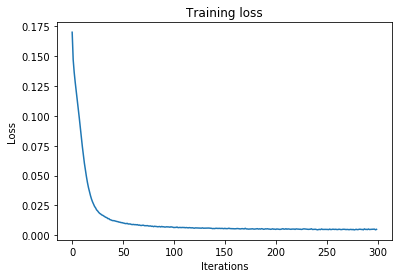

In [15]:
if training == True:
    # Save the Brevitas model to disk
    torch.save(model.state_dict(), "state_dict__224_224_class_test.pth")

    %matplotlib inline
    import matplotlib.pyplot as plt

    loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
    display_loss_plot(loss_per_epoch)

In [15]:
if training == True:
    acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
    display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

RECT:  80 30 140 140


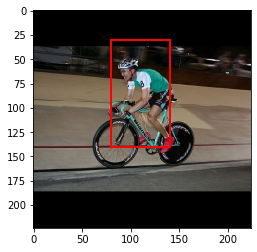

RECT:  70 50 100 110


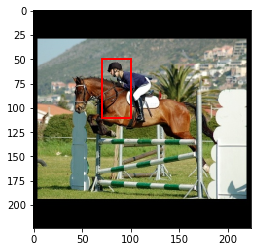

RECT:  100 50 140 160


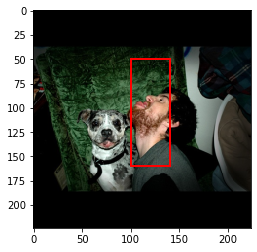

RECT:  80 80 170 120


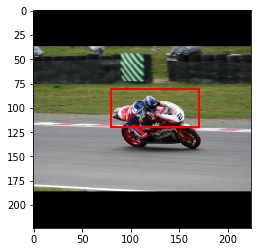

RECT:  10 90 70 160


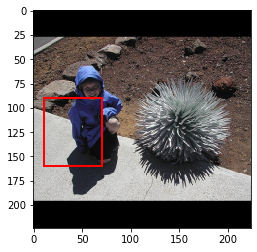

RECT:  80 80 130 170


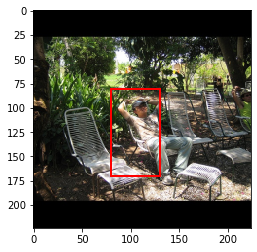

RECT:  60 0 140 190


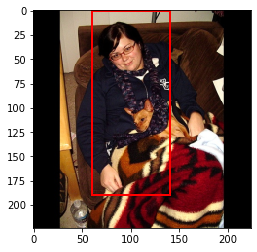

1


In [26]:
## testing

#print(torch.cuda.memory_summary(device=None, abbreviated=False))
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

it = 0

for data in test_quantized_loader:
    if training == True:
        inputs, target = data[0].to(device), data[1].to(device) 
        input_img = copy.deepcopy(inputs[0])
    if training == False:
        inputs, target = data
        input_img = copy.deepcopy(inputs[0])
    
    
    #inputs = torch.unsqueeze(inputs,1)
    
    #print(inputs)
    #print("targets shape", targets.shape)
    #print("inputs shape", inputs.shape)
    


    output_orig = model(inputs[0].float())
    #print("ORIG: ", output_orig)
    
    ot2np = output_orig.cpu().detach().numpy()
    #tt2np = targets[it].cpu().detach().numpy()
    #print("output", ot2np)
    #print("target", tt2np)
    

    
    scaling = 10
    
    xmin_pred = scaling * np.argmax( ot2np[0][0:(round((dims[0]/10)))], axis=0 )
    ymin_pred = scaling * np.argmax( ot2np[0][(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
    xmax_pred = scaling * np.argmax( ot2np[0][(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
    ymax_pred = scaling * np.argmax( ot2np[0][(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )
    
    #xmin_targ = scaling * np.argmax( tt2np[0:(round((dims[0]/10)))], axis=0 )
    #ymin_targ = scaling * np.argmax( tt2np[(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
    #xmax_targ = scaling * np.argmax( tt2np[(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
    #ymax_targ = scaling * np.argmax( tt2np[(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )
    
    print("RECT: ", xmin_pred, ymin_pred, xmax_pred, ymax_pred)
    #print("TARG: ", xmin_targ, ymin_targ, xmax_targ, ymax_targ)
    
    input_img = torch.squeeze(input_img,1)
    input_img = torch.squeeze(input_img,0)
    #print(inputs_net)
    
    
    im = input_img.cpu()
    im = np.moveaxis(np.asarray(im),0,2).astype('int32')

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)


    
    # Create a Rectangle patch
    pred_rect = patches.Rectangle((xmin_pred,ymin_pred), abs(xmax_pred-xmin_pred), abs(ymax_pred-ymin_pred), linewidth=2, edgecolor='r', facecolor='none')
    #targ_rect = patches.Rectangle((xmin_targ,ymin_targ), abs(xmax_targ-xmin_targ), abs(ymax_targ-ymin_targ), linewidth=2, edgecolor='g', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(pred_rect)
    #ax.add_patch(targ_rect)

    plt.show()
    
    it += 1
    
    #break#quit()

#print(model(x))
#print(y)

print("1")

ORIG:  [[ -8.454601    -3.1904159  -16.988964     5.064785   -24.725723
  -32.70176    -31.186314   -20.538303   -15.194356   -24.28704
  -22.17339    -17.308006   -15.433636    -8.21532     -9.970049
  -21.455545   -20.09962    -16.470522   -40.279      -25.96201
  -37.168343   -20.937103    -9.371845    -4.705863     0.19940087
   -5.8623886   -6.899274    -1.99401     -6.6599927   -4.5862226
   -9.4914875    6.02191    -12.442621   -11.126575   -15.792559
  -15.353876   -16.829443   -16.749683   -17.387766   -16.590162
  -28.992905   -40.43852    -22.41267    -21.615067   -19.461536
  -16.829443   -27.198294   -10.807533   -25.802486    -0.15952086
    2.2332911   -5.463587   -15.393756   -11.964058   -16.031837
  -12.36286    -20.29902    -23.369795   -16.07172    -17.268126
  -16.19136    -17.108604   -23.848358    -9.371846   -26.001888
  -25.96201    -19.062735   -20.618061   -19.660938   -20.219261
  -34.65589    -18.384771   -22.33291     -5.3439465   -9.770647
  -17.746687   

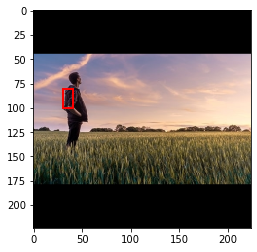

In [24]:
# test single images
import math
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = cv2.imread("/home/nm/brevitas_proj/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
top = math.floor((500 - img.shape[0]) / 2)
bottom = math.ceil((500 - img.shape[0]) / 2)
left = math.floor((500 - img.shape[1]) / 2)
right = math.ceil((500 - img.shape[1]) / 2)
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
img1 = cv2.resize(img, dims, interpolation = cv2.INTER_AREA)# resize img to fit dims
img1 = np.moveaxis(np.asarray(img1), -1, 0)

img = cv2.imread("/home/nm/brevitas_proj/test2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
top = math.floor((500 - img.shape[0]) / 2)
bottom = math.ceil((500 - img.shape[0]) / 2)
left = math.floor((500 - img.shape[1]) / 2)
right = math.ceil((500 - img.shape[1]) / 2)
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
img2 = cv2.resize(img, dims, interpolation = cv2.INTER_AREA)# resize img to fit dims
img2 = np.moveaxis(np.asarray(img2), -1, 0)
#plt.imshow(img2)

from torchvision import transforms

img1 = torch.from_numpy(img2).clone().detach()
img2 = torch.from_numpy(img2).clone().detach()


input_img = copy.deepcopy(img1)

if training == True:
    img1 = img1.to(device)


img1 = torch.unsqueeze(img1,0)
output_orig = model(img1.float())
output_orig = output_orig.cpu().detach().numpy()
print("ORIG: ", output_orig)
#print(int(round(float(output_orig[0][0]))))

xmin = scaling * np.argmax( output_orig[0][0:(round((dims[0]/10)))], axis=0 )
ymin = scaling * np.argmax( output_orig[0][(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
xmax = scaling * np.argmax( output_orig[0][(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
ymax = scaling * np.argmax( output_orig[0][(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )

print("RECT: ", xmin, ymin, xmax, ymax)

input_img = torch.squeeze(input_img,1)
input_img = torch.squeeze(input_img,0)
#print(inputs_net)


im = input_img.cpu()
im = np.moveaxis(np.asarray(im),0,2).astype('int32')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)



# Create a Rectangle patch
rect = patches.Rectangle((xmin,ymin), abs(xmax-xmin), abs(ymax-ymin), linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


In [14]:
# Save the Brevitas model to disk
torch.save(model.state_dict(), "state_dict_self-trained.pth")

# Network Surgery Before Export <a id="network_surgery"></a>

Sometimes, it's desirable to make some changes to our trained network prior to export (this is known in general as "network surgery"). This depends on the model and is not generally necessary, but in this case we want to make a couple of changes to get better results with FINN.

Let's start by padding the input. Our input vectors are 593-bit, which will make folding (parallelization) for the first layer a bit tricky since 593 is a prime number. So we'll pad the weight matrix of the first layer with seven 0-valued columns to work with an input size of 600 instead. When using the modified network we'll similarly provide inputs padded to 600 bits.

In [15]:
from copy import deepcopy

modified_model = deepcopy(model)

W_orig = modified_model.conv1.weight.data.cpu().detach().numpy()
W_orig.shape
#W_orig = modified_model[0].weight.data.detach().numpy()
#W_orig.shape

(64, 3, 3, 3)

In [16]:
import numpy as np

# pad the second (593-sized) dimensions with 24 zeroes at the end
#global padding_in
#padding_in = 24
#W_new = np.pad(W_orig, [(0,0), (0,padding_in)])
#W_new.shape

In [59]:
#modified_model[0].weight.data = torch.from_numpy(W_new)
#modified_model[0].weight.shape
#print(modified_model[0].weight[0])

Next, we'll modify the expected input/output ranges. In FINN, we prefer to work with bipolar {-1, +1} instead of binary {0, 1} values. To achieve this, we'll create a "wrapper" model that handles the pre/postprocessing as follows:

* on the input side, we'll pre-process by (x + 1) / 2 in order to map incoming {-1, +1} inputs to {0, 1} ones which the trained network is used to. Since we're just multiplying/adding a scalar, these operations can be [*streamlined*](https://finn.readthedocs.io/en/latest/nw_prep.html#streamlining-transformations) by FINN and implemented with no extra cost.

* on the output side, we'll add a binary quantizer which maps everthing below 0 to -1 and everything above 0 to +1. This is essentially the same behavior as the sigmoid we used earlier, except the outputs are bipolar instead of binary.

In [17]:
from brevitas.core.quant import QuantType
from brevitas.nn import QuantIdentity


class CybSecMLPForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(CybSecMLPForExport, self).__init__()
        self.pretrained = my_pretrained_model
        #self.qnt_output = QuantIdentity(quant_type=QuantType.INT, bit_width=8, min_val=-1.0, max_val=1.0)
    
    def forward(self, x):
        # assume x contains bipolar {-1,1} elems
        # shift from {-1,1} -> {0,1} since that is the
        # input range for the trained network
        #x = (x + torch.tensor([1.0])) / 2.0  
        out = self.pretrained(x)
        #out = self.qnt_output(out)   # output as {-1,1}     # drop quantized output
        return out

model_for_export = CybSecMLPForExport(modified_model)

In [18]:
## Test IoU accuracy of model

#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou

def test_padded_bipolar(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    its = 0
    
    with torch.no_grad():
        for data in test_loader:      
        
            inputs, target = data
            inputs = torch.squeeze(inputs,1)
            output_orig = model(inputs)
            #print(output_orig)
            #print(int(output_orig.size(dim=0)))

            pred = torch.zeros((4), dtype=torch.int64)
            true = torch.zeros((4), dtype=torch.int64)
            for i in range(int(output_orig.size(dim=0))):
                its += 1
                #print(output_orig.size())    
                #print(i)
                pred[0] = scaling * np.argmax( output_orig[i][0:(round((dims[0]/10)))], axis=0 )
                pred[1] = scaling * np.argmax( output_orig[i][(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
                pred[2] = scaling * np.argmax( output_orig[i][(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
                pred[3] = scaling * np.argmax( output_orig[i][(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )
                #print(pred)
                true[0] = target[i][0].float()
                true[1] = target[i][1].float()
                true[2] = target[i][2].float()
                true[3] = target[i][3].float()
                y_pred.append(pred.tolist())
                y_true.append(true.tolist())

             
    bbox_iou_sum = 0
    for i in range(len(y_true)):
        bbox_iou_sum += bb_intersection_over_union(y_true[i], y_pred[i])
        
    bbox_avg = bbox_iou_sum / its
    
    return bbox_avg

In [19]:
test_padded_bipolar(model_for_export, test_quantized_loader)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 5-dimensional input of size [20, 1, 3, 224, 224] instead

# Export to FINN-ONNX <a id="export_finn_onnx" ></a>


[ONNX](https://onnx.ai/) is an open format built to represent machine learning models, and the FINN compiler expects an ONNX model as input. We'll now export our network into ONNX to be imported and used in FINN for the next notebooks. Note that the particular ONNX representation used for FINN differs from standard ONNX, you can read more about this [here](https://finn.readthedocs.io/en/latest/internals.html#intermediate-representation-finn-onnx).

You can see below how we export a trained network in Brevitas into a FINN-compatible ONNX representation. Note how we create a `QuantTensor` instance with dummy data to tell Brevitas how our inputs look like, which will be used to set the input quantization annotation on the exported model.

In [65]:
import brevitas.onnx as bo
from brevitas.quant_tensor import QuantTensor

ready_model_filename = "cybsec-mlp-ready.onnx"
input_shape = (1, 3, 224, 224)
# create a QuantTensor instance to mark input as bipolar during export
input_a = np.random.randint(0, 1, size=input_shape).astype(np.float32)
scale = 1.0
input_t = torch.from_numpy(input_a * scale)
input_qt = QuantTensor(
    input_t, scale=torch.tensor(scale), bit_width=torch.tensor(8.0), signed=False
)

bo.export_finn_onnx(
    model_for_export, export_path=ready_model_filename, input_t=input_qt
)

print("Model saved to %s" % ready_model_filename)

ModuleNotFoundError: Installation of onnx and onnxoptimizer is required.

## View the Exported ONNX in Netron

Let's examine the exported ONNX model with [Netron](https://github.com/lutzroeder/netron), which is a visualizer for neural networks and allows interactive investigation of network properties. For example, you can click on the individual nodes and view the properties. Particular things of note:

* The input tensor "0" is annotated with `quantization: finn_datatype: BIPOLAR`
* The input preprocessing (x + 1) / 2 is exported as part of the network (initial `Add` and `Div` layers)
* Brevitas `QuantLinear` layers are exported to ONNX as `MatMul`. We've exported the padded version; shape of the first MatMul node's weight parameter is 600x64
* The weight parameters (second inputs) for MatMul nodes are annotated with `quantization: finn_datatype: INT2`
* The quantized activations are exported as `MultiThreshold` nodes with `domain=finn.custom_op.general`
* There's a final `MultiThreshold` node with threshold=0 to produce the final bipolar output (this is the `qnt_output` from `CybSecMLPForExport`

In [305]:
#from finn.util.visualization import showInNetron

#showInNetron(ready_model_filename)

## That's it! <a id="thats_it" ></a>
You created, trained and tested a quantized MLP that is ready to be loaded into FINN, congratulations! You can now proceed to the next notebook.

# Verify Exported ONNX Model in FINN

<font color="red">**Live FINN tutorial:** We recommend clicking **Cell -> Run All** when you start reading this notebook for "latency hiding".</font>

**Important: This notebook depends on the 1-train-mlp-with-brevitas notebook, because we are using the ONNX model that was exported there. So please make sure the needed .onnx file is generated before you run this notebook.**

**Also remember to 'close and halt' any other FINN notebooks, since Netron visualizations use the same port.**

In this notebook we will show how to import the network we trained in Brevitas and verify it in the FINN compiler. 
This verification process can actually be done at various stages in the compiler [as explained in this notebook](../bnn-pynq/tfc_end2end_verification.ipynb) but for this example we'll only consider the first step: verifying the exported high-level FINN-ONNX model.
Another goal of this notebook is to introduce you to the concept of *graph transformations* -- we'll be applying some transformations to the graph to make it executable for verification. 
Once this model is sucessfully verified, we'll generate an FPGA accelerator from it in the next notebook.

In [262]:
import onnx 
import torch 

**This is important -- always import onnx before torch**. This is a workaround for a [known bug](https://github.com/onnx/onnx/issues/2394).

## Outline
-------------
1. [Import model into FINN with ModelWrapper](#brevitas_import_visualization)
2. [Network preparations: Tidy-up transformations](#network_preparations)
3. [Load the dataset and Brevitas model](#load_dataset) 
4. [Compare FINN and Brevitas execution](#compare_brevitas)

# 1. Import model into FINN with ModelWrapper <a id="brevitas_import_visualization"></a>

Now that we have the model in .onnx format, we can work with it using FINN. To import it into FINN, we'll use the [`ModelWrapper`](https://finn.readthedocs.io/en/latest/source_code/finn.core.html#finn.core.modelwrapper.ModelWrapper). It is a wrapper around the ONNX model which provides several helper functions to make it easier to work with the model.

In [263]:
from finn.core.modelwrapper import ModelWrapper

ready_model_filename = "cybsec-mlp-ready.onnx"
model_for_sim = ModelWrapper(ready_model_filename)

Let's have a look at some of the member functions exposed by `ModelWrapper` to see what kind of information we can extract from it.

In [264]:
dir(model_for_sim)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_model_proto',
 'analysis',
 'check_all_tensor_shapes_specified',
 'check_compatibility',
 'cleanup',
 'find_consumer',
 'find_consumers',
 'find_direct_predecessors',
 'find_direct_successors',
 'find_producer',
 'find_upstream',
 'get_all_tensor_names',
 'get_finn_nodes',
 'get_initializer',
 'get_metadata_prop',
 'get_node_index',
 'get_nodes_by_op_type',
 'get_non_finn_nodes',
 'get_tensor_datatype',
 'get_tensor_fanout',
 'get_tensor_layout',
 'get_tensor_shape',
 'get_tensor_sparsity',
 'get_tensor_valueinfo',
 'graph',
 'is_fork_node',
 'is_join_node',
 'make_empty_exec_context',
 'make_new_valueinfo_name',
 'mode

Many of these helper functions relate to extracting information about the structure and properties of the ONNX model. You can find out more about examining and manipulating ONNX models programmatically in [this tutorial](../../basics/0_how_to_work_with_onnx.ipynb), but we'll show a few basic functions here. For instance, we can extract the shape and datatype annotation for various tensors in the graph, as well as information related to the operation types associated with each node.

In [265]:
from finn.core.datatype import DataType

finnonnx_in_tensor_name = model_for_sim.graph.input[0].name
finnonnx_out_tensor_name = model_for_sim.graph.output[0].name
print("Input tensor name: %s" % finnonnx_in_tensor_name)
print("Output tensor name: %s" % finnonnx_out_tensor_name)
finnonnx_model_in_shape = model_for_sim.get_tensor_shape(finnonnx_in_tensor_name)
finnonnx_model_out_shape = model_for_sim.get_tensor_shape(finnonnx_out_tensor_name)
print("Input tensor shape: %s" % str(finnonnx_model_in_shape))
print("Output tensor shape: %s" % str(finnonnx_model_out_shape))
finnonnx_model_in_dt = model_for_sim.get_tensor_datatype(finnonnx_in_tensor_name)
finnonnx_model_out_dt = model_for_sim.get_tensor_datatype(finnonnx_out_tensor_name)
print("Input tensor datatype: %s" % str(finnonnx_model_in_dt.name))
print("Output tensor datatype: %s" % str(finnonnx_model_out_dt.name))
print("List of node operator types in the graph: ")
print([x.op_type for x in model_for_sim.graph.node])

Input tensor name: 0
Output tensor name: 92
Input tensor shape: [1, 1, 24, 24]
Output tensor shape: [1, 10]
Input tensor datatype: UINT8
Output tensor datatype: FLOAT32
List of node operator types in the graph: 
['Mul', 'MultiThreshold', 'Add', 'Mul', 'Conv', 'Mul', 'Div', 'Add', 'Mul', 'MultiThreshold', 'Mul', 'MaxPool', 'Conv', 'Mul', 'Div', 'Add', 'Mul', 'MultiThreshold', 'Mul', 'MaxPool', 'Shape', 'Gather', 'Unsqueeze', 'Concat', 'Reshape', 'MatMul', 'Mul', 'Div', 'Add', 'Mul', 'MultiThreshold', 'Mul', 'MatMul', 'Mul', 'Div', 'Add', 'Mul', 'MultiThreshold', 'Mul', 'MatMul', 'Mul']


Note that the output tensor is (as of yet) marked as a float32 value, even though we know the output is binary. This will be automatically inferred by the compiler in the next step when we run the `InferDataTypes` transformation.

# 2. Network preparation: Tidy-up transformations <a id="network_preparations"></a>

Before running the verification, we need to prepare our FINN-ONNX model. In particular, all the intermediate tensors need to have statically defined shapes. To do this, we apply some graph transformations to the model like a kind of "tidy-up" to make it easier to process. 

**Graph transformations in FINN.** The whole FINN compiler is built around the idea of transformations, which gradually transform the model into a synthesizable hardware description. Although FINN offers functionality that automatically calls a standard sequence of transformations (covered in the next notebook), you can also manually call individual transformations (like we do here), as well as adding your own transformations, to create custom flows. You can read more about these transformations in [this notebook](../bnn-pynq/tfc_end2end_example.ipynb).

In [266]:
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.infer_datatypes import InferDataTypes
from finn.transformation.fold_constants import FoldConstants

model_for_sim = model_for_sim.transform(InferShapes())
model_for_sim = model_for_sim.transform(FoldConstants())
model_for_sim = model_for_sim.transform(GiveUniqueNodeNames())
model_for_sim = model_for_sim.transform(GiveReadableTensorNames())
model_for_sim = model_for_sim.transform(InferDataTypes())
model_for_sim = model_for_sim.transform(RemoveStaticGraphInputs())

verif_model_filename = "cybsec-mlp-verification.onnx"
model_for_sim.save(verif_model_filename)

**Would the FINN compiler still work if we didn't do this?** The compilation step in the next notebook applies these transformations internally and would work fine, but we're going to use FINN's verification capabilities below and these require the tidy-up transformations.

Let's view our ready-to-go model after the transformations. Note that all intermediate tensors now have their shapes specified (indicated by numbers next to the arrows going between layers). Additionally, the datatype inference step has propagated quantization annotations to the outputs of `MultiThreshold` layers (expand by clicking the + next to the name of the tensor to see the quantization annotation) and the final output tensor.

In [2]:
#from finn.util.visualization import showInNetron

#showInNetron(verif_model_filename)

# 3. Load the Dataset and the Brevitas Model <a id="load_dataset"></a>

We'll use some example data from the quantized UNSW-NB15 dataset (from the previous notebook) to use as inputs for the verification. 

In [268]:
import numpy as np
from torch.utils.data import TensorDataset

"""def get_preqnt_dataset(data_dir: str, train: bool):
    unsw_nb15_data = np.load(data_dir + "/unsw_nb15_binarized.npz")
    if train:
        partition = "train"
    else:
        partition = "test"
    part_data = unsw_nb15_data[partition].astype(np.float32)
    part_data = torch.from_numpy(part_data)
    part_data_in = part_data[:, :-1]
    part_data_out = part_data[:, -1]
    return TensorDataset(part_data_in, part_data_out)"""

n_verification_inputs = batch_size
dataloader_iterator = iter(test_quantized_loader)
input_tensor, labels = next(dataloader_iterator) #get_preqnt_dataset(".", False)
print(input_tensor)
print(input_tensor.type())
print(input_tensor.shape)


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

Let's also bring up the MLP we trained in Brevitas from the previous notebook. We'll compare its outputs to what is generated by FINN.

In [269]:
from brevitas.nn import QuantLinear, QuantReLU
import torch.nn as nn


class LowPrecisionLeNet(Module):
    def __init__(self):
        super(LowPrecisionLeNet, self).__init__()
        self.quant_inp = QuantIdentity(
            bit_width=4, return_quant_tensor=True)
        self.conv1 = QuantConv2d(
            1, 6, 5, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu1 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.conv2 = QuantConv2d(
            6, 16, 5, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu2 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc1   = QuantLinear(
            16*9, 120, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.dropout1 = nn.Dropout(p=0.5)
        self.relu3 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc2   = QuantLinear(
            120, 84, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.dropout2 = nn.Dropout(p=0.5)
        self.relu4 = QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc3   = QuantLinear(
            84, 10, bias=False, weight_bit_width=3)
        self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        out = self.quant_inp(x)
        out = self.conv1(out)
        out = self.relu1(out)
        out = F.max_pool2d(out, 2)
        out = self.conv2(out)
        out = self.relu2(out)
        out = F.max_pool2d(out, 2)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.dropout1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        out = self.dropout2(out)
        out = self.relu4(out)
        out = self.fc3(out)
        return out

brevitas_model = LowPrecisionLeNet()


# replace this with your trained network checkpoint if you're not
# using the pretrained weights
#trained_state_dict = torch.load("state_dict.pth")["models_state_dict"][0]
# Uncomment the following line if you previously chose to train the network yourself
trained_state_dict = torch.load("state_dict_self-trained.pth")

brevitas_model.load_state_dict(trained_state_dict, strict=False)

<All keys matched successfully>

In [270]:
def inference_with_brevitas(current_inp):
    brevitas_output = brevitas_model.forward(current_inp)
    """# apply sigmoid + threshold
    brevitas_output = torch.sigmoid(brevitas_output)
    brevitas_output = (brevitas_output.detach().numpy() > 0.5) * 1
    # convert output to bipolar
    brevitas_output = 2*brevitas_output - 1"""
    return brevitas_output

# 4. Compare FINN & Brevitas execution <a id="compare_brevitas"></a>

Let's make helper functions to execute the same input with Brevitas and FINN. For FINN, we'll use the [`finn.core.onnx_exec`](https://finn.readthedocs.io/en/latest/source_code/finn.core.html#finn.core.onnx_exec.execute_onnx) function to execute the exported FINN-ONNX on the inputs. Note that this ONNX execution is for verification only; not for accelerated execution.

Recall that the quantized values from the dataset are 593-bit binary {0, 1} vectors whereas our exported model takes 600-bit bipolar {-1, +1} vectors, so we'll have to preprocess it a bit before we can use it for verifying the ONNX model.

In [284]:
import finn.core.onnx_exec as oxe

def inference_with_finn_onnx(current_inp):
    finnonnx_in_tensor_name = model_for_sim.graph.input[0].name
    finnonnx_model_in_shape = model_for_sim.get_tensor_shape(finnonnx_in_tensor_name)
    finnonnx_out_tensor_name = model_for_sim.graph.output[0].name
    # convert input to numpy for FINN
    current_inp = current_inp.detach().numpy()
    # add padding and re-scale to bipolar
    current_inp = np.asarray(current_inp)
    #current_inp = 2*current_inp-1
    # reshape to expected input (add 1 for batch dimension)
    current_inp = current_inp.reshape(finnonnx_model_in_shape)
    # create the input dictionary
    input_dict = {finnonnx_in_tensor_name : current_inp} 
    # run with FINN's execute_onnx
    output_dict = oxe.execute_onnx(model_for_sim, input_dict)
    #get the output tensor
    finn_output = output_dict[finnonnx_out_tensor_name] 
    return finn_output

Now we can call our inference helper functions for each input and compare the outputs.

In [285]:
import numpy as np
from tqdm import trange

verify_range = trange(n_verification_inputs, desc="FINN execution", position=0, leave=True)
brevitas_model.eval()

ok = 0
nok = 0

for i in verify_range:
    # run in Brevitas with PyTorch tensor
    current_inp = torch.unsqueeze(input_tensor[i],1)
    brevitas_output = inference_with_brevitas(current_inp)
    brevitas_output = np.argmax(np.asarray(brevitas_output.tolist()[0]))
    print("Brevitas: ", brevitas_output)
    finn_output = inference_with_finn_onnx(current_inp)
    finn_output = np.argmax(finn_output[0])
    print("FINN: ", finn_output)
    # compare the outputs
    ok += 1 if finn_output == brevitas_output else 0
    nok += 1 if finn_output != brevitas_output else 0
    verify_range.set_description("ok %d nok %d" % (ok, nok))
    verify_range.refresh()

ok 1 nok 0:   1%|          | 1/100 [00:00<00:20,  4.78it/s]

Brevitas:  8
FINN:  8


ok 2 nok 0:   2%|▏         | 2/100 [00:00<00:20,  4.79it/s]

Brevitas:  9
FINN:  9


ok 3 nok 0:   3%|▎         | 3/100 [00:00<00:20,  4.80it/s]

Brevitas:  9
FINN:  9


ok 4 nok 0:   4%|▍         | 4/100 [00:00<00:19,  4.81it/s]

Brevitas:  6
FINN:  6


ok 5 nok 0:   5%|▌         | 5/100 [00:01<00:19,  4.80it/s]

Brevitas:  3
FINN:  3


ok 6 nok 0:   5%|▌         | 5/100 [00:01<00:19,  4.80it/s]

Brevitas:  3
FINN:  3


ok 7 nok 0:   7%|▋         | 7/100 [00:01<00:19,  4.80it/s]

Brevitas:  3
FINN:  3


ok 8 nok 0:   7%|▋         | 7/100 [00:01<00:19,  4.80it/s]

Brevitas:  7
FINN:  7


ok 9 nok 0:   9%|▉         | 9/100 [00:01<00:18,  4.81it/s]

Brevitas:  0
FINN:  0


ok 10 nok 0:  10%|█         | 10/100 [00:02<00:18,  4.81it/s]

Brevitas:  2
FINN:  2


ok 11 nok 0:  11%|█         | 11/100 [00:02<00:18,  4.81it/s]

Brevitas:  3
FINN:  3


ok 12 nok 0:  12%|█▏        | 12/100 [00:02<00:18,  4.80it/s]

Brevitas:  8
FINN:  8


ok 13 nok 0:  13%|█▎        | 13/100 [00:02<00:18,  4.80it/s]

Brevitas:  7
FINN:  7


ok 14 nok 0:  14%|█▍        | 14/100 [00:02<00:17,  4.82it/s]

Brevitas:  1
FINN:  1
Brevitas:  2


ok 15 nok 0:  15%|█▌        | 15/100 [00:03<00:17,  4.83it/s]

FINN:  2
Brevitas:  8


ok 16 nok 0:  16%|█▌        | 16/100 [00:03<00:17,  4.83it/s]

FINN:  8
Brevitas:  8


ok 17 nok 0:  17%|█▋        | 17/100 [00:03<00:17,  4.82it/s]

FINN:  8
Brevitas:  6


ok 18 nok 0:  18%|█▊        | 18/100 [00:03<00:17,  4.81it/s]

FINN:  6
Brevitas:  8


ok 19 nok 0:  19%|█▉        | 19/100 [00:03<00:16,  4.82it/s]

FINN:  8
Brevitas:  8


ok 20 nok 0:  20%|██        | 20/100 [00:04<00:16,  4.82it/s]

FINN:  8
Brevitas:  0


ok 21 nok 0:  21%|██        | 21/100 [00:04<00:16,  4.82it/s]

FINN:  0
Brevitas:  5


ok 22 nok 0:  22%|██▏       | 22/100 [00:04<00:16,  4.83it/s]

FINN:  5
Brevitas:  4


ok 23 nok 0:  23%|██▎       | 23/100 [00:04<00:15,  4.84it/s]

FINN:  4
Brevitas:  9


ok 24 nok 0:  24%|██▍       | 24/100 [00:04<00:15,  4.84it/s]

FINN:  9
Brevitas:  5


ok 25 nok 0:  25%|██▌       | 25/100 [00:05<00:15,  4.83it/s]

FINN:  5
Brevitas:  9


ok 26 nok 0:  26%|██▌       | 26/100 [00:05<00:15,  4.84it/s]

FINN:  9
Brevitas:  3


ok 27 nok 0:  27%|██▋       | 27/100 [00:05<00:15,  4.84it/s]

FINN:  3
Brevitas:  7


ok 28 nok 0:  28%|██▊       | 28/100 [00:05<00:14,  4.83it/s]

FINN:  7
Brevitas:  4


ok 29 nok 0:  29%|██▉       | 29/100 [00:06<00:14,  4.83it/s]

FINN:  4
Brevitas:  4


ok 30 nok 0:  30%|███       | 30/100 [00:06<00:14,  4.83it/s]

FINN:  4
Brevitas:  2


ok 31 nok 0:  31%|███       | 31/100 [00:06<00:14,  4.84it/s]

FINN:  2
Brevitas:  0


ok 32 nok 0:  32%|███▏      | 32/100 [00:06<00:14,  4.83it/s]

FINN:  0
Brevitas:  8


ok 33 nok 0:  33%|███▎      | 33/100 [00:06<00:13,  4.84it/s]

FINN:  8
Brevitas:  0


ok 34 nok 0:  34%|███▍      | 34/100 [00:07<00:13,  4.84it/s]

FINN:  0
Brevitas:  4


ok 35 nok 0:  35%|███▌      | 35/100 [00:07<00:13,  4.84it/s]

FINN:  4
Brevitas:  8


ok 36 nok 0:  36%|███▌      | 36/100 [00:07<00:13,  4.84it/s]

FINN:  8
Brevitas:  4


ok 37 nok 0:  37%|███▋      | 37/100 [00:07<00:13,  4.84it/s]

FINN:  4
Brevitas:  2


ok 38 nok 0:  38%|███▊      | 38/100 [00:07<00:12,  4.84it/s]

FINN:  2
Brevitas:  3


ok 39 nok 0:  39%|███▉      | 39/100 [00:08<00:12,  4.84it/s]

FINN:  3
Brevitas:  1


ok 40 nok 0:  40%|████      | 40/100 [00:08<00:12,  4.84it/s]

FINN:  1
Brevitas:  8


ok 41 nok 0:  41%|████      | 41/100 [00:08<00:12,  4.85it/s]

FINN:  8
Brevitas:  3


ok 42 nok 0:  42%|████▏     | 42/100 [00:08<00:11,  4.85it/s]

FINN:  3
Brevitas:  9


ok 43 nok 0:  43%|████▎     | 43/100 [00:08<00:11,  4.83it/s]

FINN:  9
Brevitas:  4


ok 44 nok 0:  44%|████▍     | 44/100 [00:09<00:11,  4.82it/s]

FINN:  4
Brevitas:  5


ok 46 nok 0:  46%|████▌     | 46/100 [00:09<00:11,  4.83it/s]

FINN:  5
Brevitas:  4
FINN:  4


ok 47 nok 0:  47%|████▋     | 47/100 [00:09<00:10,  4.83it/s]

Brevitas:  9
FINN:  9


ok 48 nok 0:  47%|████▋     | 47/100 [00:09<00:10,  4.83it/s]

Brevitas:  7
FINN:  7


ok 49 nok 0:  49%|████▉     | 49/100 [00:10<00:10,  4.84it/s]

Brevitas:  0
FINN:  0
Brevitas:  

ok 50 nok 0:  50%|█████     | 50/100 [00:10<00:10,  4.84it/s]

1
FINN:  1
Brevitas:  2


ok 51 nok 0:  51%|█████     | 51/100 [00:10<00:10,  4.85it/s]

FINN:  2
Brevitas:  4


ok 52 nok 0:  52%|█████▏    | 52/100 [00:10<00:09,  4.86it/s]

FINN:  4
Brevitas:  9


ok 53 nok 0:  53%|█████▎    | 53/100 [00:10<00:09,  4.86it/s]

FINN:  9
Brevitas:  2


ok 54 nok 0:  54%|█████▍    | 54/100 [00:11<00:09,  4.82it/s]

FINN:  2
Brevitas:  7


ok 55 nok 0:  55%|█████▌    | 55/100 [00:11<00:09,  4.84it/s]

FINN:  7
Brevitas:  7


ok 56 nok 0:  56%|█████▌    | 56/100 [00:11<00:09,  4.85it/s]

FINN:  7
Brevitas:  7


ok 57 nok 0:  57%|█████▋    | 57/100 [00:11<00:08,  4.85it/s]

FINN:  7
Brevitas:  0


ok 58 nok 0:  58%|█████▊    | 58/100 [00:12<00:08,  4.85it/s]

FINN:  0
Brevitas:  0


ok 59 nok 0:  59%|█████▉    | 59/100 [00:12<00:08,  4.85it/s]

FINN:  0
Brevitas:  0


ok 60 nok 0:  60%|██████    | 60/100 [00:12<00:08,  4.85it/s]

FINN:  0
Brevitas:  3


ok 61 nok 0:  61%|██████    | 61/100 [00:12<00:08,  4.84it/s]

FINN:  3
Brevitas:  3


ok 62 nok 0:  62%|██████▏   | 62/100 [00:12<00:07,  4.83it/s]

FINN:  3
Brevitas:  8


ok 63 nok 0:  63%|██████▎   | 63/100 [00:13<00:07,  4.83it/s]

FINN:  8
Brevitas:  3


ok 64 nok 0:  64%|██████▍   | 64/100 [00:13<00:07,  4.83it/s]

FINN:  3
Brevitas:  8


ok 65 nok 0:  65%|██████▌   | 65/100 [00:13<00:07,  4.83it/s]

FINN:  8
Brevitas:  1


ok 66 nok 0:  66%|██████▌   | 66/100 [00:13<00:07,  4.84it/s]

FINN:  1
Brevitas:  2


ok 67 nok 0:  67%|██████▋   | 67/100 [00:13<00:06,  4.85it/s]

FINN:  2
Brevitas:  0


ok 68 nok 0:  68%|██████▊   | 68/100 [00:14<00:06,  4.85it/s]

FINN:  0
Brevitas:  4


ok 69 nok 0:  69%|██████▉   | 69/100 [00:14<00:06,  4.86it/s]

FINN:  4
Brevitas:  9


ok 70 nok 0:  70%|███████   | 70/100 [00:14<00:06,  4.87it/s]

FINN:  9
Brevitas:  0


ok 71 nok 0:  71%|███████   | 71/100 [00:14<00:05,  4.86it/s]

FINN:  0
Brevitas:  4


ok 72 nok 0:  72%|███████▏  | 72/100 [00:14<00:05,  4.87it/s]

FINN:  4
Brevitas:  3


ok 73 nok 0:  73%|███████▎  | 73/100 [00:15<00:05,  4.87it/s]

FINN:  3
Brevitas:  9


ok 74 nok 0:  74%|███████▍  | 74/100 [00:15<00:05,  4.86it/s]

FINN:  9
Brevitas:  1


ok 75 nok 0:  75%|███████▌  | 75/100 [00:15<00:05,  4.85it/s]

FINN:  1
Brevitas:  7


ok 76 nok 0:  76%|███████▌  | 76/100 [00:15<00:04,  4.84it/s]

FINN:  7
Brevitas:  4


ok 77 nok 0:  77%|███████▋  | 77/100 [00:15<00:04,  4.84it/s]

FINN:  4
Brevitas:  5


ok 79 nok 0:  79%|███████▉  | 79/100 [00:16<00:04,  4.86it/s]

FINN:  5
Brevitas:  3
FINN:  3
Brevitas:  2


ok 80 nok 0:  80%|████████  | 80/100 [00:16<00:04,  4.85it/s]

FINN:  2
Brevitas:  0


ok 81 nok 0:  81%|████████  | 81/100 [00:16<00:03,  4.84it/s]

FINN:  0
Brevitas:  4


ok 82 nok 0:  82%|████████▏ | 82/100 [00:16<00:03,  4.84it/s]

FINN:  4
Brevitas:  5


ok 83 nok 0:  83%|████████▎ | 83/100 [00:17<00:03,  4.84it/s]

FINN:  5
Brevitas:  1


ok 85 nok 0:  85%|████████▌ | 85/100 [00:17<00:03,  4.85it/s]

FINN:  1
Brevitas:  0
FINN:  0


ok 86 nok 0:  86%|████████▌ | 86/100 [00:17<00:02,  4.84it/s]

Brevitas:  2
FINN:  2


ok 87 nok 0:  87%|████████▋ | 87/100 [00:17<00:02,  4.83it/s]

Brevitas:  2
FINN:  2


ok 88 nok 0:  88%|████████▊ | 88/100 [00:18<00:02,  4.82it/s]

Brevitas:  6
FINN:  6


ok 89 nok 0:  89%|████████▉ | 89/100 [00:18<00:02,  4.80it/s]

Brevitas:  7
FINN:  7


ok 90 nok 0:  90%|█████████ | 90/100 [00:18<00:02,  4.80it/s]

Brevitas:  6
FINN:  6


ok 91 nok 0:  91%|█████████ | 91/100 [00:18<00:01,  4.83it/s]

Brevitas:  3
FINN:  3
Brevitas:  7


ok 92 nok 0:  92%|█████████▏| 92/100 [00:19<00:01,  4.82it/s]

FINN:  7
Brevitas:  9


ok 93 nok 0:  93%|█████████▎| 93/100 [00:19<00:01,  4.83it/s]

FINN:  9
Brevitas:  6


ok 94 nok 0:  94%|█████████▍| 94/100 [00:19<00:01,  4.83it/s]

FINN:  6
Brevitas:  0


ok 95 nok 0:  95%|█████████▌| 95/100 [00:19<00:01,  4.83it/s]

FINN:  0
Brevitas:  6


ok 97 nok 0:  97%|█████████▋| 97/100 [00:20<00:00,  4.85it/s]

FINN:  6
Brevitas:  6
FINN:  6


ok 98 nok 0:  97%|█████████▋| 97/100 [00:20<00:00,  4.85it/s]

Brevitas:  2
FINN:  2


ok 99 nok 0:  99%|█████████▉| 99/100 [00:20<00:00,  4.84it/s]

Brevitas:  8
FINN:  8


ok 100 nok 0: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]

Brevitas:  4
FINN:  4


In [286]:
if ok == n_verification_inputs:
    print("Verification succeeded. Brevitas and FINN-ONNX execution outputs are identical")
else:
    print("Verification failed. Brevitas and FINN-ONNX execution outputs are NOT identical")

Verification succeeded. Brevitas and FINN-ONNX execution outputs are identical


This concludes our second notebook. In the next one, we'll take the ONNX model we just verified all the way down to FPGA hardware with the FINN compiler.

# Building the Streaming Dataflow Accelerator

<font color="red">**Live FINN tutorial:** We recommend clicking **Cell -> Run All** when you start reading this notebook for "latency hiding".</font>

**Important: This notebook depends on the 1-train-mlp-with-brevitas notebook because we are using models that were created by that notebook. So please make sure the needed .onnx files are generated prior to running this notebook.**

<img align="left" src="finn-example.png" alt="drawing" style="margin-right: 20px" width="250"/>

In this notebook, we'll use the FINN compiler generate an FPGA accelerator with a streaming dataflow architecture from our quantized MLP for the cybersecurity task. The key idea in such architectures is to parallelize across layers as well as within layers by dedicating a proportionate amount of compute resources to each layer, illustrated on the figure to the left. You can read more about the general concept in the [FINN](https://arxiv.org/pdf/1612.07119) and [FINN-R](https://dl.acm.org/doi/pdf/10.1145/3242897) papers. This is done by mapping each layer to a Vivado HLS description, parallelizing each layer's implementation to the appropriate degree and using on-chip FIFOs to link up the layers to create the full accelerator.

These implementations offer a good balance of performance and flexibility, but building them by hand is difficult and time-consuming. This is where the FINN compiler comes in: it can build streaming dataflow accelerators from an ONNX description to match the desired throughput.

## Outline
-------------

1. [Introduction to  `build_dataflow` Tool](#intro_build_dataflow) 
2. [Understanding the Build Configuration: `DataflowBuildConfig`](#underst_build_conf)     
    2.1.[Output Products](#output_prod)   
    2.2.[Configuring the Board and FPGA Part](#config_fpga)   
    2.3 [Configuring the Performance](#config_perf)    
4. [Launch a Build: Only Estimate Reports](#build_estimate_report)
5. [Launch a Build: Stitched IP, out-of-context synth and rtlsim Performance](#build_ip_synth_rtlsim)
6. [(Optional) Launch a Build: PYNQ Bitfile and Driver](#build_bitfile_driver)
7. [(Optional) Run on PYNQ board](#run_on_pynq)

## Introduction to  `build_dataflow` Tool <a id="intro_build_dataflow"></a>

Since version 0.5b, the FINN compiler has a `build_dataflow` tool. Compared to previous versions which required setting up all the needed transformations in a Python script, it makes experimenting with dataflow architecture generation easier. The core idea is to specify the relevant build info as a configuration `dict`, which invokes all the necessary steps to make the dataflow build happen. It can be invoked either from the [command line](https://finn-dev.readthedocs.io/en/latest/command_line.html) or with a single Python function call.


In this notebook, we'll use the Python function call to invoke the builds to stay inside the Jupyter notebook, but feel free to experiment with reproducing what we do here with the `./run-docker.sh build_dataflow` and `./run-docker.sh build_custom` command-line entry points too. 

## Understanding the Build Configuration: `DataflowBuildConfig` <a id="underst_build_conf"></a>

The build configuration is specified by an instance of `finn.builder.build_dataflow_config.DataflowBuildConfig`. The configuration is a Python [`dataclass`](https://docs.python.org/3/library/dataclasses.html) which can be serialized into or de-serialized from JSON files for persistence, although we'll just set it up in Python here.
There are many options in the configuration to customize different aspects of the build, we'll only cover a few of them in this notebook. You can read the details on all the config options on [the FINN API documentation](https://finn-dev.readthedocs.io/en/latest/source_code/finn.builder.html#finn.builder.build_dataflow_config.DataflowBuildConfig).

Let's go over some of the members of the `DataflowBuildConfig`:

### Output Products <a id="output_prod"></a>

The build can produce many different outputs, and some of them can take a long time (e.g. bitfile synthesis for a large network). When you first start working on generating a new accelerator and exploring the different performance options, you may not want to go all the way to a bitfile. Thus, in the beginning you may just select the estimate reports as the output products. Gradually, you can generate the output products from later stages until you are happy enough with the design to build the full accelerator integrated into a shell.

The output products are controlled by:

* `generate_outputs`: list of output products (of type [`finn.builder.build_dataflow_config.DataflowOutputType`](https://finn-dev.readthedocs.io/en/latest/source_code/finn.builder.html#finn.builder.build_dataflow_config.DataflowOutputType)) that will be generated by the build. Some available options are:
    - `ESTIMATE_REPORTS` : report expected resources and performance per layer and for the whole network without any synthesis
    - `STITCHED_IP` : create a stream-in stream-out IP design that can be integrated into other Vivado IPI or RTL designs
    - `RTLSIM_PERFORMANCE` : use PyVerilator to do a performance/latency test of the `STITCHED_IP` design
    - `OOC_SYNTH` : run out-of-context synthesis (just the accelerator itself, without any system surrounding it) on the `STITCHED_IP` design to get post-synthesis FPGA resources and achievable clock frequency
    - `BITFILE` : integrate the accelerator into a shell to produce a standalone bitfile
    - `PYNQ_DRIVER` : generate a PYNQ Python driver that can be used to launch the accelerator
    - `DEPLOYMENT_PACKAGE` : create a folder with the `BITFILE` and `PYNQ_DRIVER` outputs, ready to be copied to the target FPGA platform.
* `output_dir`: the directory where all the generated build outputs above will be written into.
* `steps`: list of predefined (or custom) build steps FINN will go through. Use `build_dataflow_config.estimate_only_dataflow_steps` to execute only the steps needed for estimation (without any synthesis), and the `build_dataflow_config.default_build_dataflow_steps` otherwise (which is the default value). You can find the list of default steps [here](https://finn.readthedocs.io/en/latest/source_code/finn.builder.html#finn.builder.build_dataflow_config.default_build_dataflow_steps) in the documentation.

### Configuring the Board and FPGA Part <a id="config_fpga"></a>

* `fpga_part`: Xilinx FPGA part to be used for synthesis, can be left unspecified to be inferred from `board` below, or specified explicitly for e.g. out-of-context synthesis.
* `board`: target Xilinx Zynq or Alveo board for generating accelerators integrated into a shell. See the `pynq_part_map` and `alveo_part_map` dicts in [this file](https://github.com/Xilinx/finn-base/blob/dev/src/finn/util/basic.py#L41) for a list of possible boards.
* `shell_flow_type`: the target [shell flow type](https://finn-dev.readthedocs.io/en/latest/source_code/finn.builder.html#finn.builder.build_dataflow_config.ShellFlowType), only needed for generating full bitfiles where the FINN design is integrated into a shell (so only needed if `BITFILE` is selected) 

### Configuring the Performance <a id="config_perf"></a>

You can configure the performance (and correspondingly, the FPGA resource footprint) of the generated dataflow accelerator in two ways:

1) (basic) Set a target performance and let the compiler figure out the per-node parallelization settings.

2) (advanced) Specify a separate .json as `folding_config_file` that lists the degree of parallelization (as well as other hardware options) for each layer.

This notebook only deals with the basic approach, for which you need to set up:

* `target_fps`: target inference performance in frames per second. Note that target may not be achievable due to specific layer constraints, or due to resource limitations of the FPGA. 
* `synth_clk_period_ns`: target clock frequency (in nanoseconds) for Vivado synthesis. e.g. `synth_clk_period_ns=5.0` will target a 200 MHz clock. Note that the target clock period may not be achievable depending on the FPGA part and design complexity.

## Launch a Build: Only Estimate Reports <a id="build_estimate_report"></a>

First, we'll launch a build that only generates the estimate reports, which does not require any synthesis. Note two things below: how the `generate_outputs` only contains `ESTIMATE_REPORTS`, but also how the `steps` uses a value of `estimate_only_dataflow_steps`. This skips steps like HLS synthesis to provide a quick estimate from analytical models.

In [287]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xczu3eg-sbva484-1-i",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)

In [288]:
%%time
build.build_dataflow_cfg(model_file, cfg_estimates)

Building dataflow accelerator from cybsec-mlp-ready.onnx
Intermediate outputs will be generated in /tmp/finn_dev_nm
Final outputs will be generated in output_estimates_only
Build log is at output_estimates_only/build_dataflow.log
Running step: step_qonnx_to_finn [1/8]
Running step: step_tidy_up [2/8]
Running step: step_streamline [3/8]
Running step: step_convert_to_hls [4/8]
Running step: step_create_dataflow_partition [5/8]
Running step: step_target_fps_parallelization [6/8]
Running step: step_apply_folding_config [7/8]
Running step: step_generate_estimate_reports [8/8]
Completed successfully
CPU times: user 1.83 s, sys: 7.75 ms, total: 1.84 s
Wall time: 1.71 s


0

We'll now examine the generated outputs from this build. If we look under the outputs directory, we'll find a subfolder with the generated estimate reports.

In [289]:
! ls {estimates_output_dir}

auto_folding_config.json  intermediate_models  time_per_step.json
build_dataflow.log	  report


In [290]:
! ls {estimates_output_dir}/report

estimate_layer_config_alternatives.json  estimate_network_performance.json
estimate_layer_cycles.json		 op_and_param_counts.json
estimate_layer_resources.json


We see that various reports have been generated as .json files. Let's examine the contents of the `estimate_network_performance.json` for starters. Here, we can see the analytical estimates for the performance and latency.

In [291]:
! cat {estimates_output_dir}/report/estimate_network_performance.json

{
  "critical_path_cycles": 47650,
  "max_cycles": 10120,
  "max_cycles_node_name": "ConvolutionInputGenerator_0",
  "estimated_throughput_fps": 9881.422924901186,
  "estimated_latency_ns": 476500.0
}

Since all of these reports are .json files, we can easily load them into Python for further processing. This can be useful if you are building your own design automation tools on top of FINN. Let's define a helper function and look at the `estimate_layer_cycles.json` report.

In [292]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

In [293]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

{'Thresholding_Batch_0': 576,
 'ConvolutionInputGenerator_0': 10120,
 'StreamingFCLayer_Batch_0': 2400,
 'StreamingMaxPool_Batch_0': 600,
 'ConvolutionInputGenerator_1': 5700,
 'StreamingFCLayer_Batch_1': 8640,
 'StreamingMaxPool_Batch_1': 54,
 'StreamingFCLayer_Batch_2': 8640,
 'StreamingFCLayer_Batch_3': 10080,
 'StreamingFCLayer_Batch_4': 840}

Here, we can see the estimated number of clock cycles each layer will take. Recall that all of these layers will be running in parallel, and the slowest layer will determine the overall throughput of the entire neural network. FINN attempts to parallelize each layer such that they all take a similar number of cycles, and less than the corresponding number of cycles that would be required to meet `target_fps`. Additionally by summing up all layer cycle estimates one can obtain an estimate for the overall latency of the whole network. 

Finally, we can see the layer-by-layer resource estimates in the `estimate_layer_resources.json` report:

In [294]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")

{'Thresholding_Batch_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 8,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 324,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingFCLayer_Batch_0': {'BRAM_18K': 3,
  'BRAM_efficiency': 0.008138020833333334,
  'LUT': 1664,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingMaxPool_Batch_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 324,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingFCLayer_Batch_1': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.390625,
  'LUT': 1188,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingMaxPool_Batch_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingFCLayer_Batch_2': {'BRAM_18K': 5,


This particular report is useful to determine whether the current configuration will fit into a particular FPGA. If you see that the resource requirements are too high for the FPGA you had in mind, you should consider lowering the `target_fps`.

**Note that the analytical models tend to over-estimate how much resources are needed, since they can't capture the effects of various synthesis optimizations.**

## Launch a Build: Stitched IP, out-of-context synth and rtlsim Performance <a id="build_ip_synth_rtlsim"></a>

Once we have a configuration that gives satisfactory estimates, we can move on to generating the accelerator. We can do this in different ways depending on how we want to integrate the accelerator into a larger system. For instance, if we have a larger streaming system built in Vivado or if we'd like to re-use this generated accelerator as an IP component in other projects, the `STITCHED_IP` output product is a good choice. We can also use the `OOC_SYNTH` output product to get post-synthesis resource and clock frequency numbers for our accelerator.

<font color="red">**Live FINN tutorial:** These next builds will take about 10 minutes to complete since multiple calls to Vivado and a call to RTL simulation are involved. While this is running, you can examine the generated files with noVNC -- it is running on **(your AWS URL):6080/vnc.html**

* Once the `step_hls_codegen [8/16]` below is completed, you can view the generated HLS code under its own folder for each layer: `/tmp/finn_dev_ubuntu/code_gen_ipgen_StreamingFCLayer_Batch_XXXXXX`
    
* Once the `step_create_stitched_ip [11/16]` below is completed, you can view the generated stitched IP in Vivado under `/home/ubuntu/finn/notebooks/end2end_example/cybersecurity/output_ipstitch_ooc_rtlsim/stitched_ip`
</font> 

In [295]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

rtlsim_output_dir = "output_ipstitch_ooc_rtlsim"

#Delete previous run results if exist
if os.path.exists(rtlsim_output_dir):
    shutil.rmtree(rtlsim_output_dir)
    print("Previous run results deleted!")

cfg_stitched_ip = build.DataflowBuildConfig(
    output_dir          = rtlsim_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xczu3eg-sbva484-1-i",
    generate_outputs=[
        build_cfg.DataflowOutputType.STITCHED_IP,
        build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
        build_cfg.DataflowOutputType.OOC_SYNTH,
    ]
)

In [296]:
%%time
build.build_dataflow_cfg(model_file, cfg_stitched_ip)

Building dataflow accelerator from cybsec-mlp-ready.onnx
Intermediate outputs will be generated in /tmp/finn_dev_nm
Final outputs will be generated in output_ipstitch_ooc_rtlsim
Build log is at output_ipstitch_ooc_rtlsim/build_dataflow.log
Running step: step_qonnx_to_finn [1/17]
Running step: step_tidy_up [2/17]
Running step: step_streamline [3/17]
Running step: step_convert_to_hls [4/17]
Running step: step_create_dataflow_partition [5/17]
Running step: step_target_fps_parallelization [6/17]
Running step: step_apply_folding_config [7/17]
Running step: step_generate_estimate_reports [8/17]
Running step: step_hls_codegen [9/17]
Running step: step_hls_ipgen [10/17]
Running step: step_set_fifo_depths [11/17]
Running step: step_create_stitched_ip [12/17]
Running step: step_measure_rtlsim_performance [13/17]
Running step: step_out_of_context_synthesis [14/17]
Running step: step_synthesize_bitfile [15/17]
Running step: step_make_pynq_driver [16/17]
Running step: step_deployment_package [17/17

0

Why is e.g. `step_synthesize_bitfile` listed above even though we didn't ask for a bitfile in the output products? This is because we're using the default set of build steps, which includes `step_synthesize_bitfile`. Since its output product is not selected, this step will do nothing.

Among the output products, we will find the accelerator exported as a stitched IP block design:

In [297]:
! ls {rtlsim_output_dir}/stitched_ip

all_verilog_srcs.txt		       finn_vivado_stitch_proj.xpr
finn_vivado_stitch_proj.cache	       ip
finn_vivado_stitch_proj.gen	       make_project.sh
finn_vivado_stitch_proj.hw	       make_project.tcl
finn_vivado_stitch_proj.ip_user_files  vivado.jou
finn_vivado_stitch_proj.srcs	       vivado.log


We also have a few reports generated by these output products, different from the ones generated by `ESTIMATE_REPORTS`.

In [298]:
! ls {rtlsim_output_dir}/report

estimate_layer_resources_hls.json  rtlsim_performance.json
ooc_synth_and_timing.json


In `ooc_synth_and_timing.json` we can find the post-synthesis and maximum clock frequency estimate for the accelerator. Note that the clock frequency estimate here tends to be optimistic, since out-of-context synthesis is less constrained.

In [299]:
! cat {rtlsim_output_dir}/report/ooc_synth_and_timing.json

{
  "vivado_proj_folder": "/tmp/finn_dev_nm/synth_out_of_context_x6s1ci28/results_finn_design_wrapper",
  "LUT": 6037.0,
  "FF": 7483.0,
  "DSP": 0.0,
  "BRAM": 7.0,
  "WNS": 3.688,
  "": 0,
  "fmax_mhz": 158.42839036755387,
  "estimated_throughput_fps": 15654.979285331408
}

In `rtlsim_performance.json` we can find the steady-state throughput and latency for the accelerator, as obtained by rtlsim. If the DRAM bandwidth numbers reported here are below what the hardware platform is capable of (i.e. the accelerator is not memory-bound), you can expect the same steady-state throughput (excluding any software/driver overheads) in real hardware.

In [300]:
! cat {rtlsim_output_dir}/report/rtlsim_performance.json

{
  "cycles": 34287,
  "runtime[ms]": 0.34287,
  "throughput[images/s]": 2916.557295768075,
  "DRAM_in_bandwidth[Mb/s]": 1.6799370023624114,
  "DRAM_out_bandwidth[Mb/s]": 0.0583311459153615,
  "fclk[mhz]": 100.0,
  "N": 1,
  "latency_cycles": 34287
}

Finally, let's have a look at `final_hw_config.json`. This is the node-by-node hardware configuration determined by the FINN compiler, including FIFO depths, parallelization settings (PE/SIMD) and others. If you want to optimize your build further (the "advanced" method we mentioned under "Configuring the performance"), you can use this .json file as the `folding_config_file` for a new run to use it as a starting point for further exploration and optimizations.

In [301]:
! cat {rtlsim_output_dir}/final_hw_config.json

{
  "Defaults": {},
  "StreamingFIFO_0": {
    "ram_style": "auto",
    "depth": 2,
    "impl_style": "rtl"
  },
  "Thresholding_Batch_0": {
    "PE": 1,
    "ram_style": "distributed",
    "mem_mode": "const",
    "runtime_writeable_weights": 0
  },
  "StreamingFIFO_1": {
    "ram_style": "auto",
    "depth": 128,
    "impl_style": "rtl"
  },
  "ConvolutionInputGenerator_0": {
    "SIMD": 1,
    "ram_style": "distributed"
  },
  "StreamingDataWidthConverter_Batch_0": {
    "impl_style": "hls"
  },
  "StreamingFCLayer_Batch_0": {
    "PE": 1,
    "SIMD": 25,
    "ram_style": "auto",
    "resType": "lut",
    "mem_mode": "decoupled",
    "runtime_writeable_weights": 0
  },
  "StreamingDataWidthConverter_Batch_1": {
    "impl_style": "hls"
  },
  "StreamingFIFO_6": {
    "ram_style": "auto",
    "depth": 32,
    "impl_style": "rtl"
  },
  "StreamingDataWidthConverter_Batch_2": {
    "impl_style": "hls"
  },
  "StreamingFIFO_7": {
    "ram_style": "auto",
    "depth": 64,
    "impl_style"

## (Optional) Launch a Build: PYNQ Bitfile and Driver <a id="build_bitfile_driver"></a>

<font color="red">**Live FINN tutorial:** This section is not included in the hands-on tutorial due to the bitfile synthesis time (15-20 min). If you own a PYNQ board, we encourage you to uncomment the cells below to try it out on your own after the tutorial.</font>

In [17]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

final_output_dir = "output_final"

#Delete previous run results if exist
if os.path.exists(final_output_dir):
    shutil.rmtree(final_output_dir)
    print("Previous run results deleted!")

cfg = build.DataflowBuildConfig(
    output_dir          = final_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    board               = "Pynq-Z1",
    shell_flow_type     = build_cfg.ShellFlowType.VIVADO_ZYNQ,
    generate_outputs=[
        build_cfg.DataflowOutputType.BITFILE,
        build_cfg.DataflowOutputType.PYNQ_DRIVER,
        build_cfg.DataflowOutputType.DEPLOYMENT_PACKAGE,
    ]
)

In [18]:
#%%time
#build.build_dataflow_cfg(model_file, cfg)

Building dataflow accelerator from cybsec-mlp-ready.onnx
Intermediate outputs will be generated in /tmp/finn_dev_ubuntu
Final outputs will be generated in output_final
Build log is at output_final/build_dataflow.log
Running step: step_tidy_up [1/16]
Running step: step_streamline [2/16]
Running step: step_convert_to_hls [3/16]
Running step: step_create_dataflow_partition [4/16]
Running step: step_target_fps_parallelization [5/16]
Running step: step_apply_folding_config [6/16]
Running step: step_generate_estimate_reports [7/16]
Running step: step_hls_codegen [8/16]
Running step: step_hls_ipgen [9/16]
Running step: step_set_fifo_depths [10/16]
Running step: step_create_stitched_ip [11/16]
Running step: step_measure_rtlsim_performance [12/16]
Running step: step_make_pynq_driver [13/16]
Running step: step_out_of_context_synthesis [14/16]
Running step: step_synthesize_bitfile [15/16]
Running step: step_deployment_package [16/16]
Completed successfully
CPU times: user 4.47 s, sys: 766 ms, tot

0

For our final build, the output products include the bitfile (and the accompanying .hwh file, also needed to execute correctly on PYNQ for Zynq platforms):

In [19]:
#! ls {final_output_dir}/bitfile

finn-accel.bit	finn-accel.hwh


The generated Python driver lets us execute the accelerator on PYNQ platforms with simply numpy i/o. You can find some notebooks showing how to use FINN-generated accelerators at runtime in the [finn-examples](https://github.com/Xilinx/finn-examples) repository.

In [20]:
#! ls {final_output_dir}/driver

driver.py  driver_base.py  finn  runtime_weights  validate.py


The reports folder contains the post-synthesis resource and timing reports:

In [21]:
#! ls {final_output_dir}/report

estimate_layer_resources_hls.json  post_synth_resources.xml
post_route_timing.rpt


Finally, we have the `deploy` folder which contains everything you need to copy onto the target board to get the accelerator running:

In [22]:
#! ls {final_output_dir}/deploy

bitfile  driver


## (Optional) Run on PYNQ board <a id="run_on_pynq"></a>

<font color="red">**Live FINN tutorial:** This section is not included in the hands-on tutorial due to the bitfile synthesis time (15-20 min) of the previous section. If you own a PYNQ board, we encourage you to uncomment the cells below to try it out on your own after the tutorial.</font>

To test the accelerator on the board, we'll put a copy of the dataset and a premade Python script that validates the accuracy into the `driver` folder, then make a zip archive of the whole deployment folder.

In [23]:
#! cp unsw_nb15_binarized.npz {final_output_dir}/deploy/driver

In [24]:
#! cp validate-unsw-nb15.py {final_output_dir}/deploy/driver

In [25]:
#! ls {final_output_dir}/deploy/driver

driver.py	finn		 unsw_nb15_binarized.npz  validate.py
driver_base.py	runtime_weights  validate-unsw-nb15.py


In [26]:
#from shutil import make_archive
#make_archive('deploy-on-pynq', 'zip', final_output_dir+"/deploy")

'/workspace/finn/notebooks/end2end_example/cybersecurity/deploy-on-pynq.zip'

You can now download the created zipfile (**File -> Open**, mark the checkbox next to the `deploy-on-pynq.zip` and select Download from the toolbar), then copy it to your PYNQ board (for instance via `scp` or `rsync`). Then, run the following commands **on the PYNQ board** to extract the archive and run the validation:

```shell
unzip deploy-on-pynq.zip -d finn-cybsec-mlp-demo
cd finn-cybsec-mlp-demo/driver
sudo python3.6 -m pip install bitstring
sudo python3.6 validate-unsw-nb15.py --batchsize 1000
```

You should see `Final accuracy: 91.868293` at the end. You may have noticed that the validation doesn't *quite* run at 1M inferences per second. This is because of the Python packing/unpacking and data movement overheads. To see this in more detail, the generated driver includes a benchmarking mode that shows the runtime breakdown:

```shell
sudo python3.6 driver.py --exec_mode throughput_test --bitfile ../bitfile/finn-accel.bit --batchsize 1000
cat nw_metrics.txt
```

```{'runtime[ms]': 1.0602474212646484,
 'throughput[images/s]': 943176.0737575893,
 'DRAM_in_bandwidth[Mb/s]': 70.7382055318192,
 'DRAM_out_bandwidth[Mb/s]': 0.9431760737575894,
 'fclk[mhz]': 100.0,
 'batch_size': 1000,
 'fold_input[ms]': 9.679794311523438e-05,
 'pack_input[ms]': 0.060115814208984375,
 'copy_input_data_to_device[ms]': 0.002428770065307617,
 'copy_output_data_from_device[ms]': 0.0005249977111816406,
 'unpack_output[ms]': 0.3773000240325928,
 'unfold_output[ms]': 6.818771362304688e-05}```

Here, the various `pack_input/unpack_output` calls show the overhead of packing/unpacking the inputs/outputs to convert from numpy arrays to the bit-contiguous data representation our accelerator expects. The `copy_input_data_to_device` and `copy_output_data_from_device` indicate the cost of moving the data between the CPU and accelerator memories. These overheads can dominate the execution time when running with small batch sizes.

Finally, we can see that `throughput[images/s]`, which is the pure hardware throughput without any software and data movement overheads, is close to 1M inferences per second.